# 0. Data Pre-Processing and EDA

Overview:
- This notebook will perform image pre-processing and EDA to ensure standard inputs to the eventual machine learning classifiers
- The process will include the following:
    - Size and Channels standardization
    - Normalization of all images
    - Ensuring all images are of the same data-type

### 0. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)'

/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
from skimage.feature import hog
from skimage import data, exposure
from utils import *
from skimage.filters import difference_of_gaussians
from skimage.filters import laplace
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error
from scipy import stats

### 1. Load all images, plot shape distribution, and show example images

In [4]:
# Setup Data Paths
cwd = os.getcwd()
data_path = os.path.join(cwd,'data')
training_path = os.path.join(data_path,'Training')

# Initialize Data Variables
X_train = []
Y_train = []
image_file_names = []

# Load in Images and Labels
for label in os.listdir(training_path):
    label_path = os.path.join(training_path,label)
    for image in os.listdir(label_path):
        image_file_names.append(image)
        image_path = os.path.join(label_path,image)
        img_array = plt.imread(image_path)
        X_train.append(img_array)
        Y_train.append(label)

# Shuffle Data for Randomization
np.random.seed(281)
indices = [i for i in range(0,len(X_train))]
shuffle_indices = np.random.permutation(indices)
X_train_shuffled = [X_train[i] for i in shuffle_indices]
Y_train_shuffled = [Y_train[i] for i in shuffle_indices]

In [5]:
img_shapes = [img.shape for img in X_train_shuffled]
label_names = list(set(Y_train_shuffled))

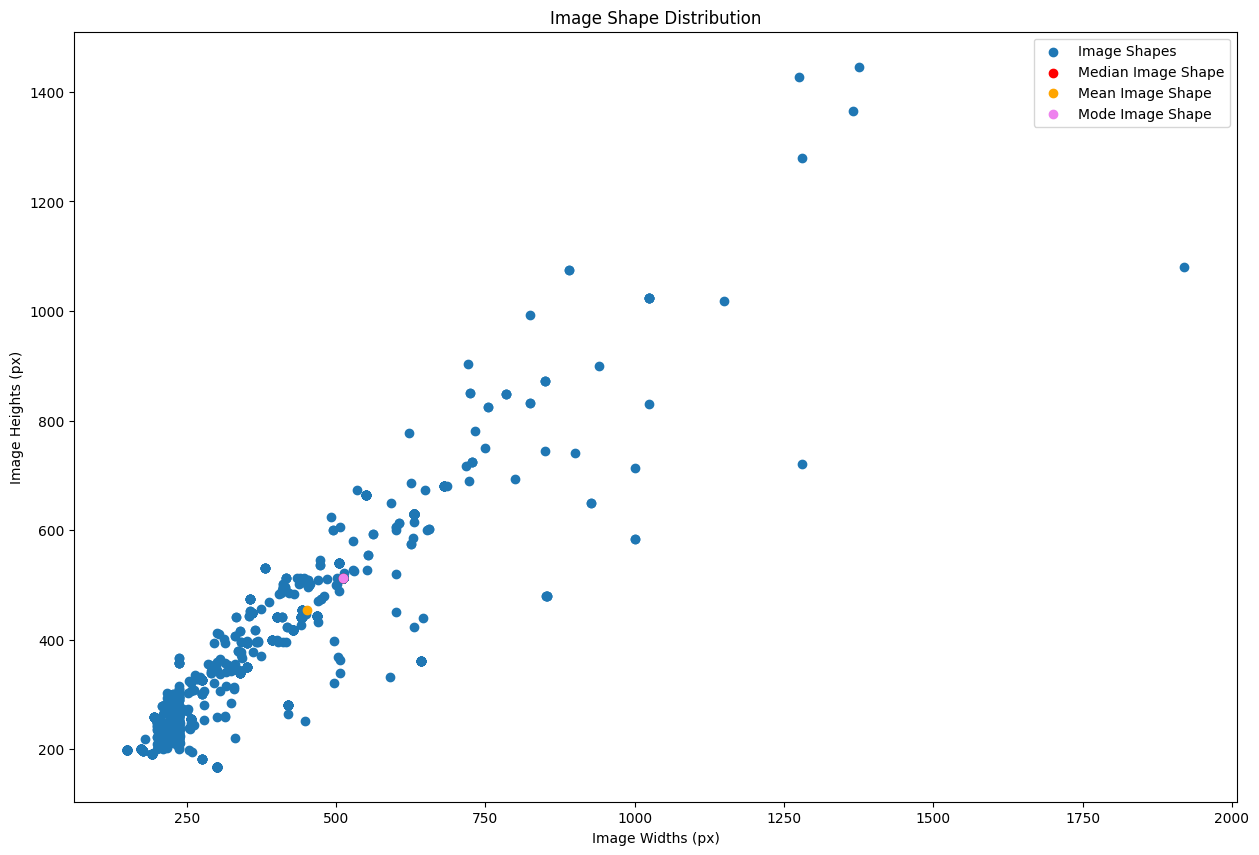

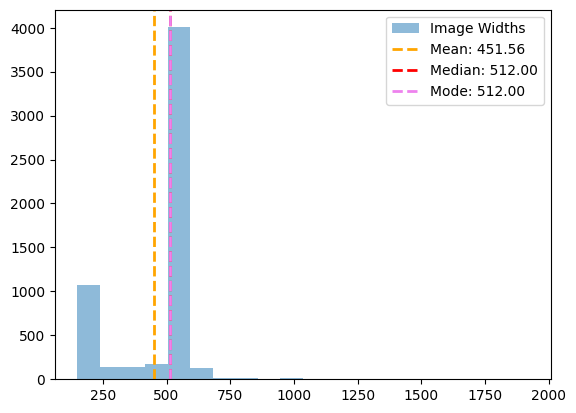

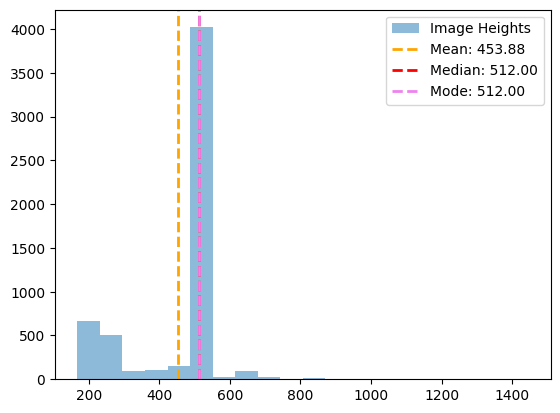

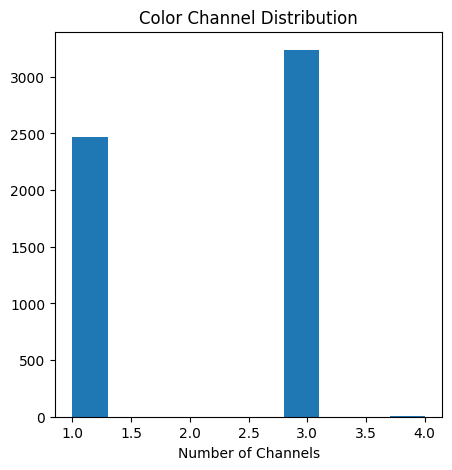

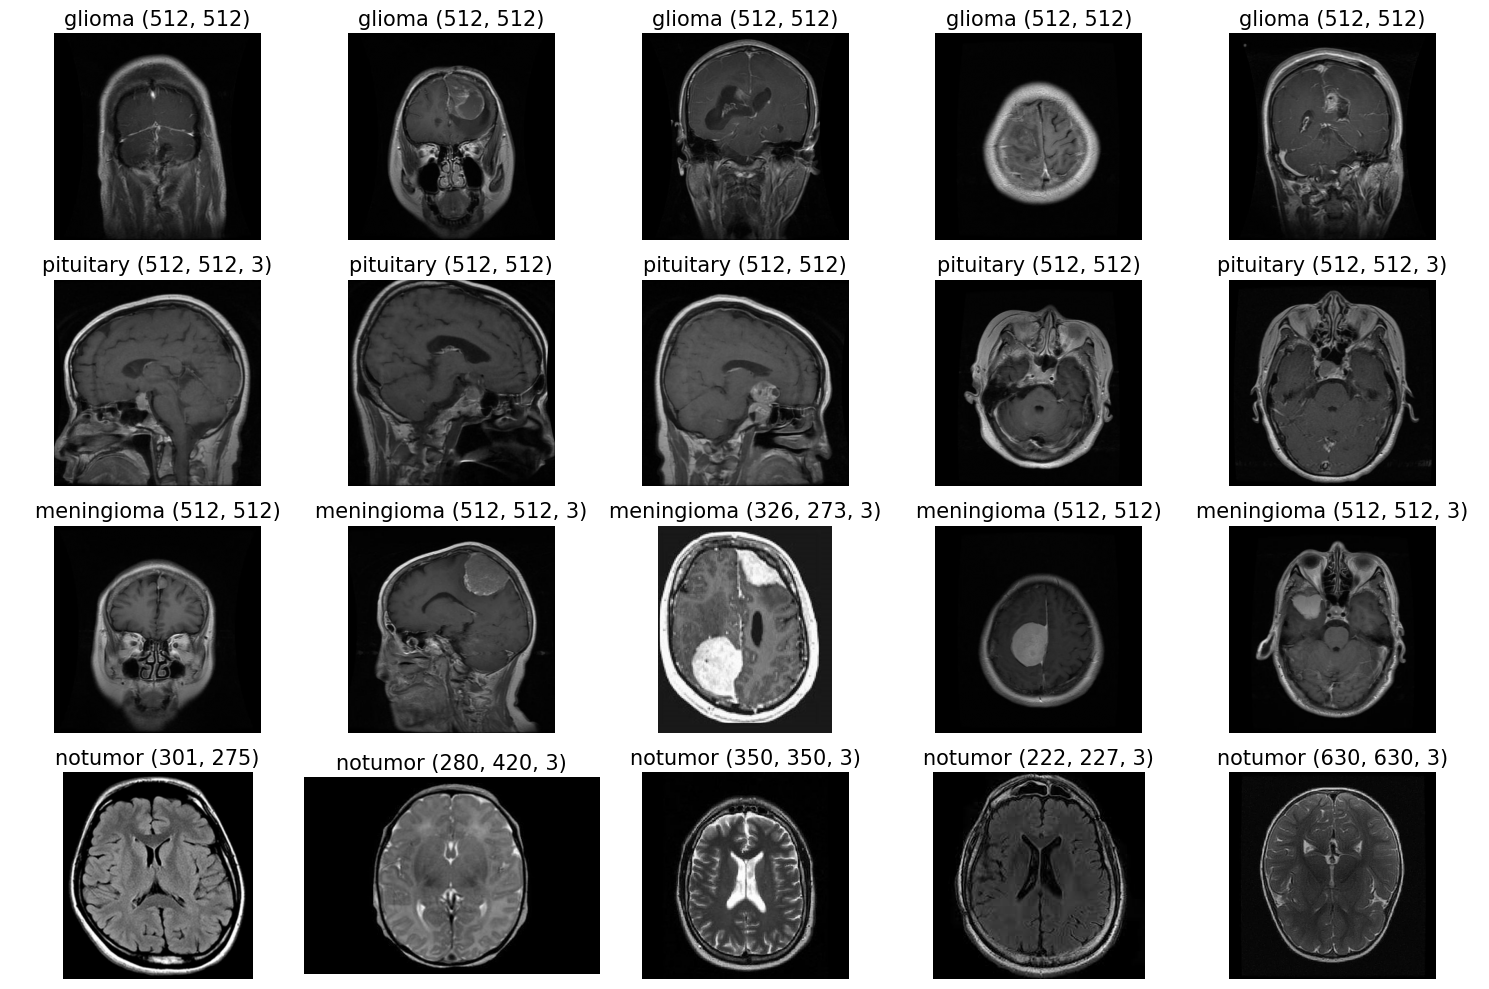

In [6]:
# Plot Distribution of Image Shapes
img_shape_widths = [img[1] for img in img_shapes]
img_shape_heights = [img[0] for img in img_shapes]
median_img_shape_widths = np.median(img_shape_widths)
median_img_shape_heights = np.median(img_shape_heights)
mean_img_shape_widths = np.mean(img_shape_widths)
mean_img_shape_heights = np.mean(img_shape_heights)
mode_img_shape_widths = stats.mode(img_shape_widths)[0]
mode_img_shape_heights = stats.mode(img_shape_heights)[0]
plt.figure(figsize=(15,10))
plt.scatter(img_shape_widths, img_shape_heights,label="Image Shapes")
plt.scatter(median_img_shape_widths, median_img_shape_heights,label="Median Image Shape",color='red')
plt.scatter(mean_img_shape_widths, mean_img_shape_heights,label="Mean Image Shape",color='orange')
plt.scatter(mode_img_shape_widths, mode_img_shape_heights,label="Mode Image Shape",color='violet')
plt.legend()
plt.title("Image Shape Distribution")
plt.xlabel("Image Widths (px)")
plt.ylabel("Image Heights (px)")
plt.show()

plt.hist(img_shape_widths, bins=20, alpha=0.5, label='Image Widths')
plt.axvline(mean_img_shape_widths, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {mean_img_shape_widths:.2f}')
plt.axvline(median_img_shape_widths, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_img_shape_widths:.2f}')
plt.axvline(mode_img_shape_widths, color='violet', linestyle='dashed', linewidth=2, label=f'Mode: {mode_img_shape_widths:.2f}')
plt.legend(loc='upper right')
plt.show()

plt.hist(img_shape_heights, bins=20, alpha=0.5, label='Image Heights')
plt.axvline(mean_img_shape_heights, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {mean_img_shape_heights:.2f}')
plt.axvline(median_img_shape_heights, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_img_shape_heights:.2f}')
plt.axvline(mode_img_shape_heights, color='violet', linestyle='dashed', linewidth=2, label=f'Mode: {mode_img_shape_heights:.2f}')
plt.legend(loc='upper right')
plt.show()

# Channel Distribution
channel_size = [shape[2] if len(shape) > 2 else 1 for shape in img_shapes]
plt.figure(figsize = (5,5))
plt.hist(channel_size)
plt.title("Color Channel Distribution")
plt.xlabel("Number of Channels")

# Plot Example Images of Each Label
plt.figure(figsize = (15,10))
plt.axis('off')
column_indexer = 0
while column_indexer < 20:
    for label in label_names:
        index_pos = [i for i, x in enumerate(Y_train_shuffled) if x == label]
        for counter in range(0,5):
            image_index_value = index_pos[counter]
            plt.subplot(4,5,column_indexer+counter+1)
            plt.title(label +' ' + str(img_shapes[image_index_value]), fontsize=15)
            plt.axis('off')
            plt.imshow(X_train_shuffled[image_index_value], cmap='gray')
        column_indexer = column_indexer + 5
plt.tight_layout()
plt.show()

### 2. Resolution/sizing Standardization

In [7]:
# normalize grayscale image with intensity range between 0-1
def normalize_image(img):
    # convert to floating point image with intensity [0, 1]
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0
    img = normalize_img(img)

    # convert to grayscale
    if len(img.shape) == 3:
      if img.shape[2] == 3:
        img = rgb2gray(img)
      elif img.shape[2] == 4:
        img = cv.cvtColor(img, cv.COLOR_RGBA2BGR)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # TODO: handle GSI (gray scale inversion)

    return img

## TODO SOLN 1: rescale short side to standard size, then crop center
def rescale_image(img, standard=256):
  # rescale short side to standard size, then crop center
  scale = standard / min(img.shape[:2])
  img = rescale(img, scale, anti_aliasing=True)
  img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
            int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]
  return img

In [8]:
X_train_standardized = []
for image in X_train:
  image = normalize_image(image)
  image = rescale_image(image, median_img_shape_widths)
  X_train_standardized.append(image)

In [9]:
X_train_standardized_shuffled = [X_train_standardized[i] for i in shuffle_indices]
img_shapes = [img.shape for img in X_train_standardized_shuffled]

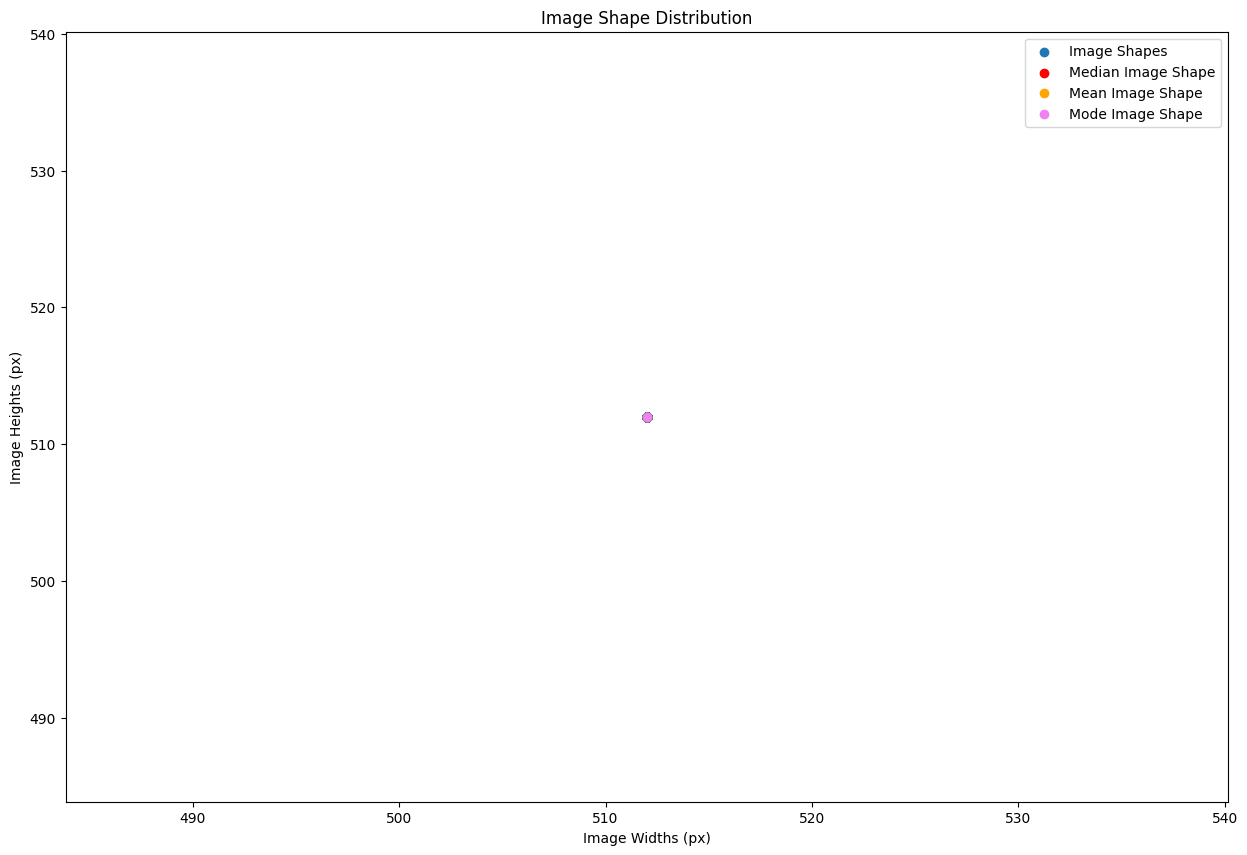

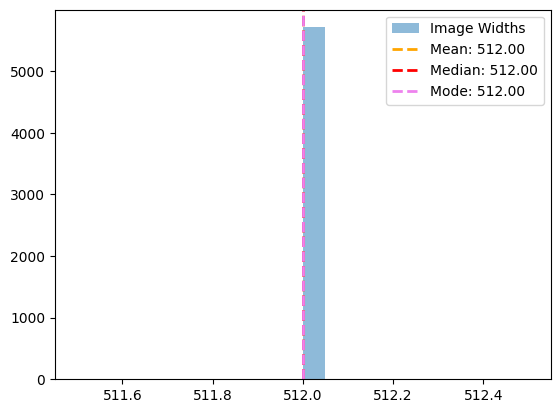

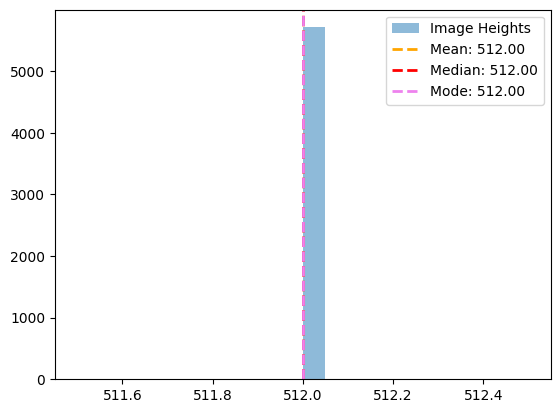

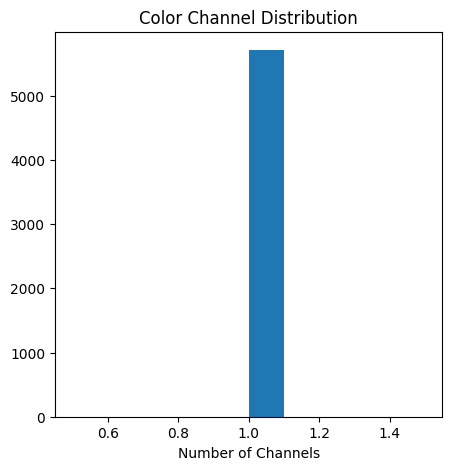

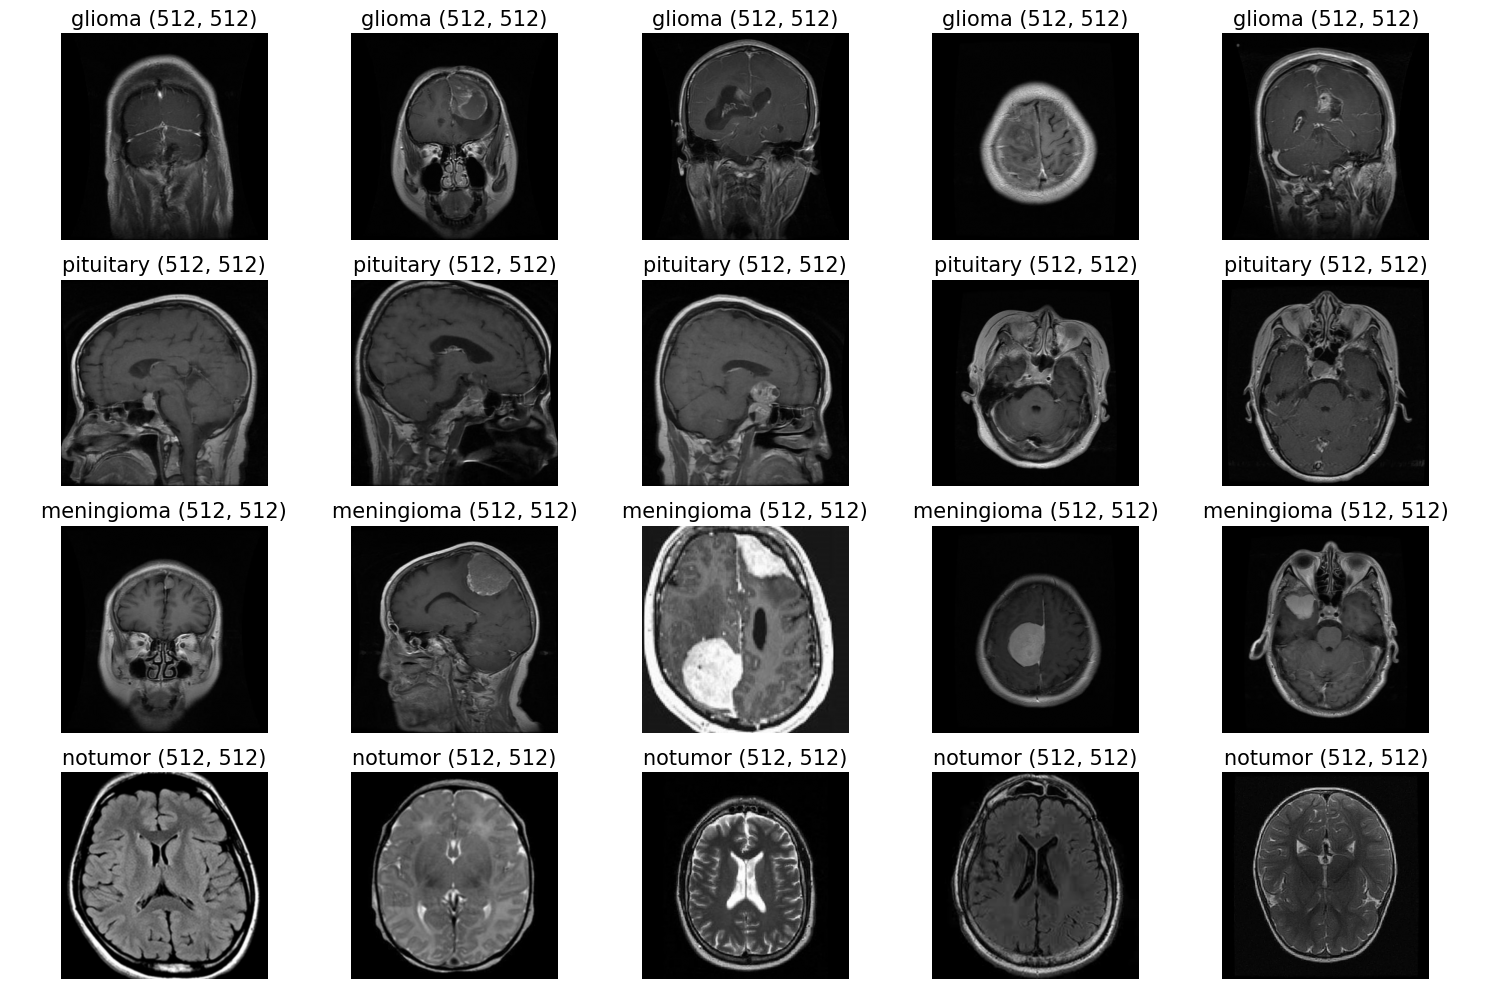

In [10]:
# Plot Distribution of Image Shapes
img_shape_widths = [img[1] for img in img_shapes]
img_shape_heights = [img[0] for img in img_shapes]
median_img_shape_widths = np.median(img_shape_widths)
median_img_shape_heights = np.median(img_shape_heights)
mean_img_shape_widths = np.mean(img_shape_widths)
mean_img_shape_heights = np.mean(img_shape_heights)
mode_img_shape_widths = stats.mode(img_shape_widths)[0]
mode_img_shape_heights = stats.mode(img_shape_heights)[0]
plt.figure(figsize=(15,10))
plt.scatter(img_shape_widths, img_shape_heights,label="Image Shapes")
plt.scatter(median_img_shape_widths, median_img_shape_heights,label="Median Image Shape",color='red')
plt.scatter(mean_img_shape_widths, mean_img_shape_heights,label="Mean Image Shape",color='orange')
plt.scatter(mode_img_shape_widths, mode_img_shape_heights,label="Mode Image Shape",color='violet')
plt.legend()
plt.title("Image Shape Distribution")
plt.xlabel("Image Widths (px)")
plt.ylabel("Image Heights (px)")
plt.show()

plt.hist(img_shape_widths, bins=20, alpha=0.5, label='Image Widths')
plt.axvline(mean_img_shape_widths, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {mean_img_shape_widths:.2f}')
plt.axvline(median_img_shape_widths, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_img_shape_widths:.2f}')
plt.axvline(mode_img_shape_widths, color='violet', linestyle='dashed', linewidth=2, label=f'Mode: {mode_img_shape_widths:.2f}')
plt.legend(loc='upper right')
plt.show()

plt.hist(img_shape_heights, bins=20, alpha=0.5, label='Image Heights')
plt.axvline(mean_img_shape_heights, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {mean_img_shape_heights:.2f}')
plt.axvline(median_img_shape_heights, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_img_shape_heights:.2f}')
plt.axvline(mode_img_shape_heights, color='violet', linestyle='dashed', linewidth=2, label=f'Mode: {mode_img_shape_heights:.2f}')
plt.legend(loc='upper right')
plt.show()

# Channel Distribution
channel_size = [shape[2] if len(shape) > 2 else 1 for shape in img_shapes]
plt.figure(figsize = (5,5))
plt.hist(channel_size)
plt.title("Color Channel Distribution")
plt.xlabel("Number of Channels")

# Plot Example Images of Each Label
plt.figure(figsize = (15,10))
plt.axis('off')
column_indexer = 0
while column_indexer < 20:
    for label in label_names:
        index_pos = [i for i, x in enumerate(Y_train_shuffled) if x == label]
        for counter in range(0,5):
            image_index_value = index_pos[counter]
            plt.subplot(4,5,column_indexer+counter+1)
            plt.title(label +' ' + str(img_shapes[image_index_value]), fontsize=15)
            plt.axis('off')
            plt.imshow(X_train_standardized_shuffled[image_index_value], cmap='gray')
        column_indexer = column_indexer + 5
plt.tight_layout()
plt.show()

In [11]:
# Define the base directory for saving standardized images
standardized_data_path = os.path.join(cwd, 'standardized_data')
training_output_path = os.path.join(standardized_data_path, 'Training')

# Create the base directory and training sub-directory if they don't exist
os.makedirs(training_output_path, exist_ok=True)

# Iterate through the standardized images and their corresponding labels
for i, image in enumerate(X_train_standardized):
    label = Y_train[i] # Use original Y_train for correct labels

    # Create the label sub-directory if it doesn't exist
    label_output_path = os.path.join(training_output_path, label)
    os.makedirs(label_output_path, exist_ok=True)

    # Define the output file path
    # Using a simple index for the filename, you might want a more robust naming scheme
    output_filename = image_file_names[i]
    output_filepath = os.path.join(label_output_path, output_filename)

    # Save the image
    # Since the images are already standardized and likely float between 0 and 1,
    # we can use matplotlib's imsave or convert to uint8 first.
    # Using imsave as it handles float data appropriately.
    plt.imsave(output_filepath, image, cmap='gray')

print(f"Standardized images saved to: {training_output_path}")


Standardized images saved to: /content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)/standardized_data/Training


### 3. Class Distribution

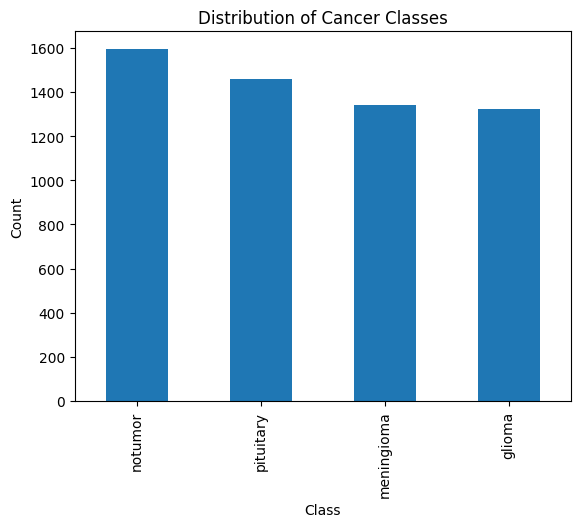

In [12]:
y_train_series = pd.Series(Y_train)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()